In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['medium', 'publication', 'article', 'live','platform','story','write'])

In [4]:
df = pd.read_csv('blog_medium.csv',error_bad_lines=False,skipinitialspace=False,sep=';',index_col=0)
print(df.Description.unique())
df


['The original flagship publication of Medium'
 "Medium's largest active publication, followed by +668K people. Follow to join our community."
 'This is no longer updated. Go to https://freecodecamp.org/news instead'
 ...
 '“Every project is never the solitary expression of a concept but it represents the synthesis of a complex thinking”'
 'Here I’m publishing own political analysis, poetry, pictures, and diary entries. For academe, see my academia dot edu profile.'
 'Learnings from building an ecommerce website\u200a—\u200aproduct development, full stack web, analytics, startup economics etc']


,Name,Description,Followers
0,Matter,The original flagship publication of Medium,"1,036,488"
1,The Startup,"Medium's largest active publication, followed ...","668,651"
2,freeCodeCamp.org,This is no longer updated. Go to https://freec...,"612,452"
3,Mission.org,A network of business & tech podcasts designed...,"542,542"
4,Personal Growth,Sharing our ideas and experiences.,"494,533"
...,...,...,...
11860,Pomme de Terre,The writings of one Leo Teixeira concerning th...,0
11861,WildPlum,Snippets of personal anecdotes and culture sho...,0
11862,The Thinking Behind,“Every project is never the solitary expressio...,-1
11863,Khayati,"Here I’m publishing own political analysis, po...",-1


In [5]:
# Convert to list
df['data'] = df.Description.tolist()
data=df['data']

In [6]:
# Pre-processing steps for data

df['data'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\_', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in df['data']]

# Remove new line characters
df['data'] = [re.sub('\s+', ' ', str(sent)) for sent in df['data']]

# Remove distracting single quotes
df['data'] = [re.sub("\'", " ", str(sent)) for sent in df['data']]

#Converting into lowercase
df['data']=df['data'].str.lower()

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['data']))

print(data_words[:1])

[['the', 'original', 'flagship', 'publication', 'of', 'medium']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'original', 'flagship', 'publication', 'of', 'medium']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['original', 'flagship']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           minimum_probability=0.01,
                                           passes=80,
                                           alpha='auto')

In [18]:
lda_model.show_topics(num_topics=5, num_words=5, formatted=False)

[(0,
  [('story', 0.053748507),
   ('life', 0.047225095),
   ('write', 0.02764704),
   ('people', 0.024237623),
   ('personal', 0.018988978)]),
 (1,
  [('make', 0.03357523),
   ('thing', 0.023061754),
   ('place', 0.019180004),
   ('blog', 0.018627645),
   ('new', 0.018556377)]),
 (2,
  [('world', 0.02555974),
   ('technology', 0.024948224),
   ('design', 0.023007369),
   ('learn', 0.022378486),
   ('article', 0.017906507)]),
 (3,
  [('art', 0.01772053),
   ('provide', 0.017365469),
   ('collection', 0.015050984),
   ('creative', 0.014838761),
   ('writing', 0.013128123)]),
 (4,
  [('share', 0.03350789),
   ('help', 0.032404087),
   ('experience', 0.030149646),
   ('business', 0.02907184),
   ('work', 0.024884379)])]

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.019555532155415

Coherence Score:  0.22806032687533198


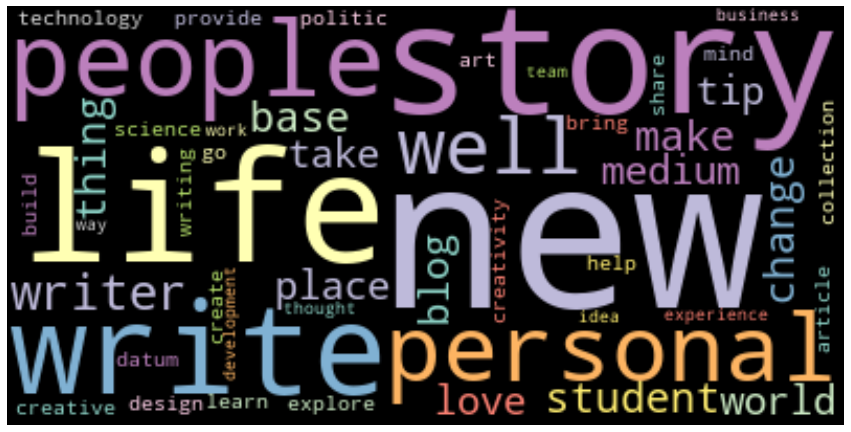

In [20]:
from wordcloud import WordCloud

from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in lda_model.show_topics())
wordcloud = WordCloud(max_words=2000,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()


In [21]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.364627 -0.007295       1        1  28.907255
4      0.108445 -0.313364       2        1  20.634975
1      0.103469  0.221602       3        1  18.840374
0      0.092803  0.074770       4        1  17.653133
3      0.059911  0.024287       5        1  13.964264, topic_info=          Term        Freq       Total Category  logprob  loglift
41       story  789.000000  789.000000  Default  30.0000  30.0000
133       life  693.000000  693.000000  Default  29.0000  29.0000
25       share  575.000000  575.000000  Default  28.0000  28.0000
209       make  526.000000  526.000000  Default  27.0000  27.0000
104       help  556.000000  556.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
508    discuss   82.470367   83.235130   Topic5  -4.9468   1.9594
616     public   79.990562   80.742393   Topic5  -4.9773   1.9593
243  political   79.860695   80.622978   Topic5  -4.9789   1.9592
210      other   79.875999   80.645905   Topic5  -4.9788   1.9591
525    program   75.114197   75.884308   Topic5  -5.0402   1.9585

[182 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
170       4  0.995893   advice
403       5  0.994161       ai
1437      5  0.993965      aim
658       3  0.989231     also
49        5  0.998003      art
...     ...       ...      ...
48        1  0.998710    world
73        4  0.999086    write
603       4  0.997687   writer
271       5  0.992718  writing
428       5  0.996501    young

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])